In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import lightning.pytorch as pl
import torch
import gc
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, Subset, DataLoader
from typing import Dict, List, Tuple

In [2]:
PATH_ROOT = Path(r'C:\Caesar\Machine_Learning\projects\my_cityscapes_scripts\data')
PATH_MODEL = Path(r'C:\Caesar\Machine_Learning\projects\detr\experiments\detection_0\detr')
PATH_SAVE_EXPERIMENT = Path(r'C:\Caesar\Machine_Learning\projects\detr\experiments\panoptic_0')

train_annFile = Path(r'C:\Caesar\Machine_Learning\projects\my_cityscapes_scripts\data\annotations\cityscapes_panoptic_train.json')
train_masksDir = Path(r'C:\Caesar\Machine_Learning\projects\my_cityscapes_scripts\data\annotations\cityscapes_panoptic_train')
val_annFile = Path(r'C:\Caesar\Machine_Learning\projects\my_cityscapes_scripts\data\annotations\cityscapes_panoptic_val.json')
val_masksDir = Path(r'C:\Caesar\Machine_Learning\projects\my_cityscapes_scripts\data\annotations\cityscapes_panoptic_val')

In [3]:
class CityscapesPanopticAPI:

    def __init__(self, root, annFile):
        self.root = root
        self.annFile = annFile

        if not self.annFile.exists():
            raise FileNotFoundError(f'Annotation file not found at {self.annFile}.')

        print('loading annotations into memory...')
        with open(self.annFile, 'r') as f:
            self.annotations = json.load(f)
        
        print('creating index...')
        self.categories = self.annotations['categories']
        for cat in self.categories: cat['isthing'] = True if cat['isthing'] == 1 else False
        self.images = self.annotations['images']
        self.annotations = self.annotations['annotations']

        self.ids = [img['id'] for img in self.images]

        print('index created!')

    def loadImg(self, image_id):
        return self.loadImgs([image_id])[0]
    
    def loadAnns(self, image_id):
        return [ann for ann in self.annotations if ann['image_id'] == image_id]

    def loadImgs(self, image_ids):
        images = list(filter(lambda img: img['id'] in image_ids, self.images))
        return [Image.open(self.root / img['file_name']) for img in images]
    
    def getImageIds(self):
        return [img['id'] for img in self.images]
    
    def getCategoryById(self, category_id):
        return next((cat for cat in self.categories if cat['id'] == category_id), None)

    def __getitem__(self, image_id):
        return self.loadImg(image_id), self.loadAnns(image_id)

In [4]:
cityscapesAPIs = {
    'train': CityscapesPanopticAPI(PATH_ROOT, train_annFile),
    'val': CityscapesPanopticAPI(PATH_ROOT, val_annFile)
}

loading annotations into memory...
creating index...
index created!
loading annotations into memory...
creating index...
index created!


In [5]:
cityscapesAPIs['train'].categories

[{'id': 0,
  'name': 'road',
  'supercategory': 'flat',
  'isthing': False,
  'color': [0.5019607843137255, 0.25098039215686274, 0.5019607843137255]},
 {'id': 1,
  'name': 'sidewalk',
  'supercategory': 'flat',
  'isthing': False,
  'color': [0.9568627450980393, 0.13725490196078433, 0.9098039215686274]},
 {'id': 2,
  'name': 'building',
  'supercategory': 'construction',
  'isthing': False,
  'color': [0.27450980392156865, 0.27450980392156865, 0.27450980392156865]},
 {'id': 3,
  'name': 'wall',
  'supercategory': 'construction',
  'isthing': False,
  'color': [0.4, 0.4, 0.611764705882353]},
 {'id': 4,
  'name': 'fence',
  'supercategory': 'construction',
  'isthing': False,
  'color': [0.7450980392156863, 0.6, 0.6]},
 {'id': 5,
  'name': 'pole',
  'supercategory': 'object',
  'isthing': False,
  'color': [0.6, 0.6, 0.6]},
 {'id': 6,
  'name': 'traffic light',
  'supercategory': 'object',
  'isthing': False,
  'color': [0.9803921568627451, 0.6666666666666666, 0.11764705882352941]},
 {'i

In [6]:
class CityscapesPanopticDataset(Dataset):

    def __init__(self, cityscapesAPI: CityscapesPanopticAPI, masksDir: str, feature_extractor=None) -> None:
        self.cityscapesAPI = cityscapesAPI
        self.masksDir = Path(masksDir)
        self.feature_extractor = feature_extractor

        self.image_ids = [img['id'] for img in self.cityscapesAPI.images]

        print('index created!')
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image, anns = self.cityscapesAPI[self.image_ids[idx]]

        if self.feature_extractor:
            encoding = self.feature_extractor(
                images=[image], 
                annotations=anns, 
                masks_path=self.masksDir,
                return_tensors="pt")
            
            return encoding["pixel_values"].squeeze(), encoding["labels"][0]
        else:
            return image, anns

In [7]:
train_dataset = CityscapesPanopticDataset(cityscapesAPIs['train'], train_masksDir)

index created!


In [8]:
img, target = train_dataset[0]

In [9]:
target[0].keys()

dict_keys(['image_id', 'file_name', 'segments_info'])

In [10]:
def gtFinePanopticToSegmIdsMask(gtFinePanoptic):
    segmIdsMask = gtFinePanoptic[:, :, 2] * 256 * 256
    segmIdsMask += gtFinePanoptic[:, :, 1] * 256
    segmIdsMask += gtFinePanoptic[:, :, 0]
    return segmIdsMask.astype(np.uint32)

In [11]:
def segmIdsMaskToColorMask(
        segmIdsMask: np.ndarray, 
        segmInfo: List[Dict[str, any]], 
        id2color: List[Tuple[int, Tuple[int, int, int]]]) -> np.ndarray:
    colorMask = np.zeros((segmIdsMask.shape[0], segmIdsMask.shape[1], 3), np.float32)
    for segm in segmInfo:
        colorMask[segmIdsMask == segm['id']] = id2color[segm['category_id']]

    return colorMask

In [12]:
def showAnns(image, target, masksDir, include_nonThings=False):
    gtFinePanotpic = Image.open(Path(masksDir) / target['file_name'])

    segmIdsMask = gtFinePanopticToSegmIdsMask(np.array(gtFinePanotpic))
    id2color = {cat['id']: cat['color'] for cat in cityscapesAPIs['val'].categories}
    colorMask = segmIdsMaskToColorMask(segmIdsMask, target['segments_info'], id2color)

    plt.figure(figsize=(16, 10))
    plt.imshow(image)
    plt.imshow(colorMask, alpha=0.5)

    for segmInfo in target['segments_info']:
        category = cityscapesAPIs['val'].getCategoryById(segmInfo['category_id'])
        if category['isthing'] == False and not include_nonThings: 
            continue

        x, y, w, h = segmInfo['bbox']
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color=category['color'], linewidth=2))
        plt.text(x, y, category['name'], fontsize=12, color='white')
    
    plt.axis('off')
    plt.show()

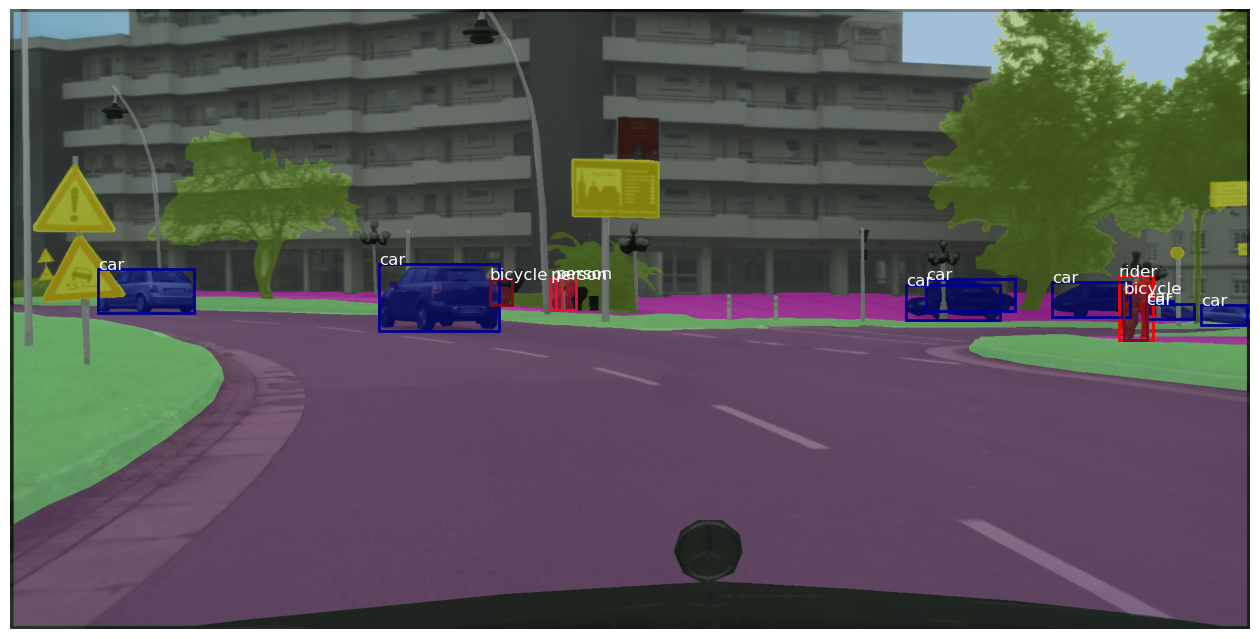

In [13]:
showAnns(img, target[0], train_masksDir, include_nonThings=False)

In [14]:
from transformers import DetrFeatureExtractor

feature_extractor_panoptic = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")

c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [15]:
def collate_fn(batch):
    pixel_values, labels = list(zip(*batch))
    encoding = feature_extractor_panoptic.pad(pixel_values, return_tensors="pt")
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

In [16]:
train_dataset = CityscapesPanopticDataset(cityscapesAPIs['train'], train_masksDir, feature_extractor_panoptic)
val_dataset = CityscapesPanopticDataset(cityscapesAPIs['val'], val_masksDir, feature_extractor_panoptic)

index created!
index created!


In [17]:
train_dataset = Subset(train_dataset, np.random.choice(len(train_dataset), 1))
val_dataset = Subset(val_dataset, np.random.choice(len(val_dataset), 1))

In [18]:
train_dataLoader = DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn)
val_dataLoader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn)

In [19]:
batch = next(iter(train_dataLoader))
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [20]:
batch['labels'][0].keys()

dict_keys(['size', 'image_id', 'orig_size', 'masks', 'boxes', 'class_labels', 'iscrowd', 'area'])

In [21]:
print('Shape of masks:', batch['labels'][0]['masks'].shape)
print('Shape of boxes:', batch['labels'][0]['boxes'].shape)
print('Shape of class labels:', batch['labels'][0]['class_labels'].shape)

Shape of masks: torch.Size([10, 666, 1332])
Shape of boxes: torch.Size([10, 4])
Shape of class labels: torch.Size([10])


In [22]:
from transformers import DetrForSegmentation

model = DetrForSegmentation.from_pretrained(PATH_MODEL)

In [23]:
with torch.no_grad():
    outputs = model(**batch)    

In [24]:
outputs.keys()

odict_keys(['loss', 'loss_dict', 'logits', 'pred_boxes', 'pred_masks', 'last_hidden_state', 'encoder_last_hidden_state'])

In [25]:
class PanopticModel(pl.LightningModule):

    def __init__(self, model, lr=1e-4, weight_decay=1e-4):
        super().__init__()
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay

        # freeze the detection module
        self.model.detr.requires_grad_(False)
    
    def forward(self, pixel_values, pixel_mask, labels=None):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self.model(**batch)

        self.log('train/loss', outputs['loss'], on_step=True, on_epoch=True, prog_bar=True)
        self.log_dict(
            {f'train/{k}': v for k, v in outputs['loss_dict'].items()},
            on_step=False, on_epoch=True, prog_bar=True)
            
        return outputs['loss']

    def validation_step(self, batch, batch_idx):
        outputs = self.model(**batch)

        self.log('val/loss', outputs['loss'], on_step=False, on_epoch=True, prog_bar=True)
        self.log_dict(
            {f'val/{k}': v for k, v in outputs['loss_dict'].items()},
            on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

In [26]:
model_pl = PanopticModel(model)

In [27]:
trainer = pl.Trainer(
    max_epochs=5, 
    accelerator="auto", 
    logger=True, 
    gradient_clip_val=0.1,
    default_root_dir=PATH_SAVE_EXPERIMENT)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
torch.cuda.empty_cache()
gc.collect()

117

In [29]:
trainer.fit(model_pl, train_dataloaders=train_dataLoader)

c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: C:\Caesar\Machine_Learning\projects\detr\experiments\panoptic_0\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | DetrForSegmentation | 42.8 M
----------------------------------------------
1.3 M     Trainable params
41.5 M    Non-trainable params
42.8 M    Total params
171.360   Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 680.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 2.39 GiB is allocated by PyTorch, and 474.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)